In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

import os

In [2]:
from google.colab import drive
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
#data=pd.read_csv("/drive/MyDrive/Projects/Freeway_Project/TGSIM_Processed/I395_Analyze.csv")
data=pd.read_csv("/drive/MyDrive/Projects/Freeway_Project/I94/I94sample.csv")
all_lanes = [10,11,12,13,14,15]

In [4]:
data.columns

Index(['Unnamed: 0', 'ID', 'time', 'xloc-kf', 'yloc-kf', 'lane-kf', 'speed-kf',
       'acceleration-kf', 'length-smoothed', 'width-smoothed',
       'type-most-common', 'segment', 'dist_cntr', 'lane_group'],
      dtype='object')

In [5]:
min_t=0
max_t=300
min_x=100
max_x=500

lc_dur= 4
rel_data=data[(data["time"]>=min_t) & (data["time"]<=max_t) & (data["dist_cntr"]>=min_x) & (data["dist_cntr"]<=max_x)  ]

lc_times_by_id={} # get the lc time to adjust for the lc effects
rel_data["lane_vis"]=rel_data["lane-kf"].values

all_ids=rel_data["ID"].unique()
for id in all_ids:
  lc_times_by_id[id]={}
  veh=rel_data[rel_data["ID"]==id]
  # detect the lc locations and time
  veh_lane1=veh["lane-kf"].values[1:]
  veh_lane0=veh["lane-kf"].values[:-1]
  veh_time=veh["time"].values[1:]
  veh_time0=veh["time"].values[:-1]
  veh_lc_idx = np.where(veh_lane1!=veh_lane0)[0]
  # get where
  for idx in veh_lc_idx:
    lc_time=veh_time[idx]
    old_lane = veh_lane0[idx]
    new_lane = veh_lane1[idx]
    # get the new lane
    lc_times_by_id[id][lc_time]=[old_lane, new_lane]
    # change the rel_data

    veh_mask = (
            (rel_data["ID"] == id) &
            (rel_data["time"] >= lc_time- lc_dur//2) &
            (rel_data["time"] <= lc_time + lc_dur//2)
        ) # the sub data that is relevant for this vehicle
    # implement gradually changing lanes

    rel_data.loc[veh_mask, "lane_vis"] = (rel_data.loc[veh_mask, "time"] - (lc_time - lc_dur//2) ) * (new_lane - old_lane) / lc_dur  +  old_lane
    #print(veh_mask


<ipython-input-5-37413867ca1e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_data["lane_vis"]=rel_data["lane-kf"].values
<ipython-input-5-37413867ca1e>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11.    10.975 10.95  10.925 10.9   10.875 10.85  10.825 10.8   10.775
 10.75  10.725 10.7   10.675 10.65  10.625 10.6   10.575 10.55  10.525
 10.5   10.475 10.45  10.425 10.4   10.375 10.35  10.325 10.3   10.275
 10.25  10.225 10.2   10.175 10.15  10.125]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rel_data.loc[veh_mask, "lane_vis"] = (rel_data.loc[veh_mask, "time"] - (lc_time - lc_dur//2) ) * (new_lane - old_lan

In [6]:
animation_dir="I90_94_vis"
#os.mkdir(animation_dir)

<ipython-input-10-3bf789a0892a>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")


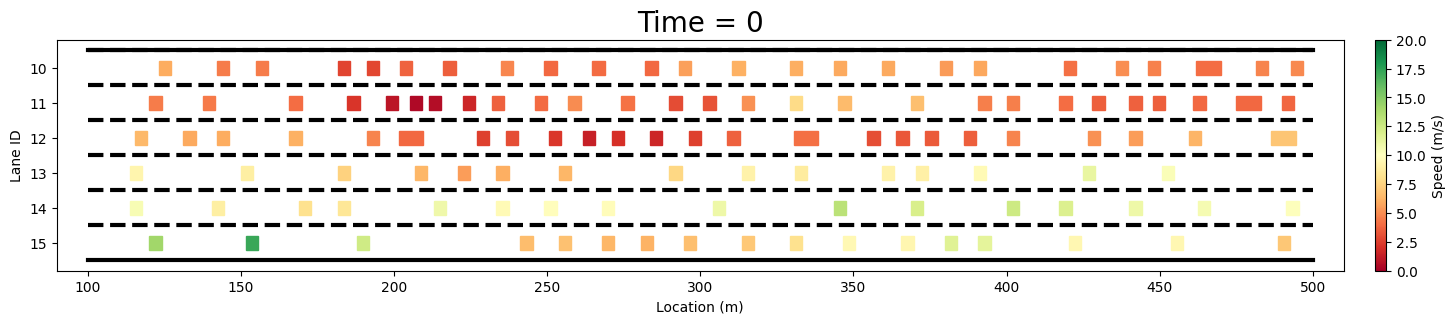

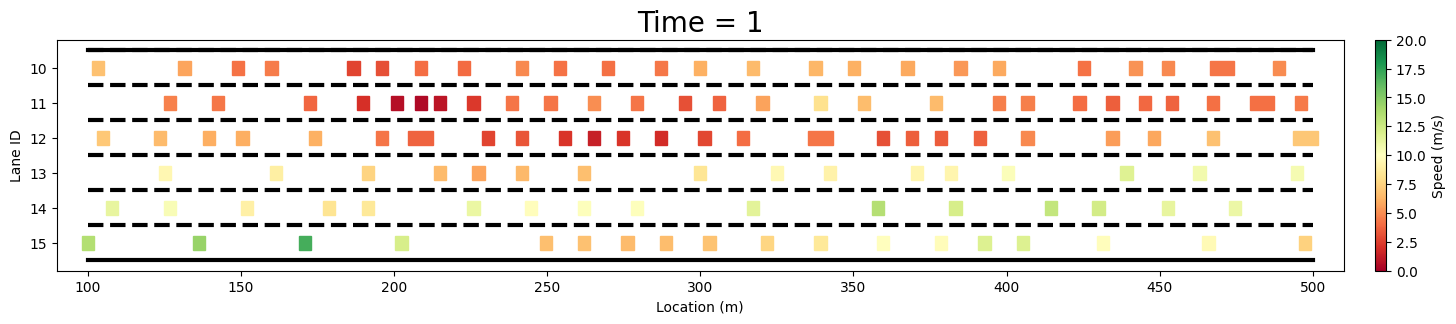

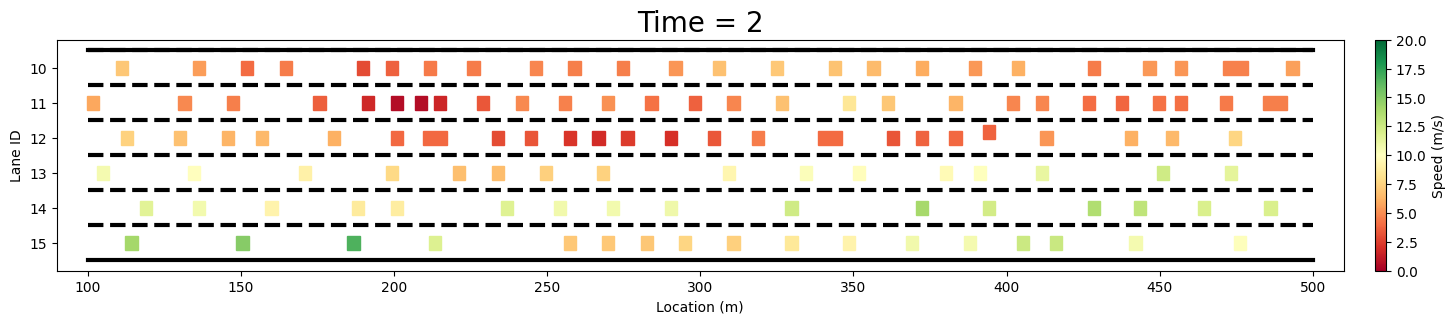

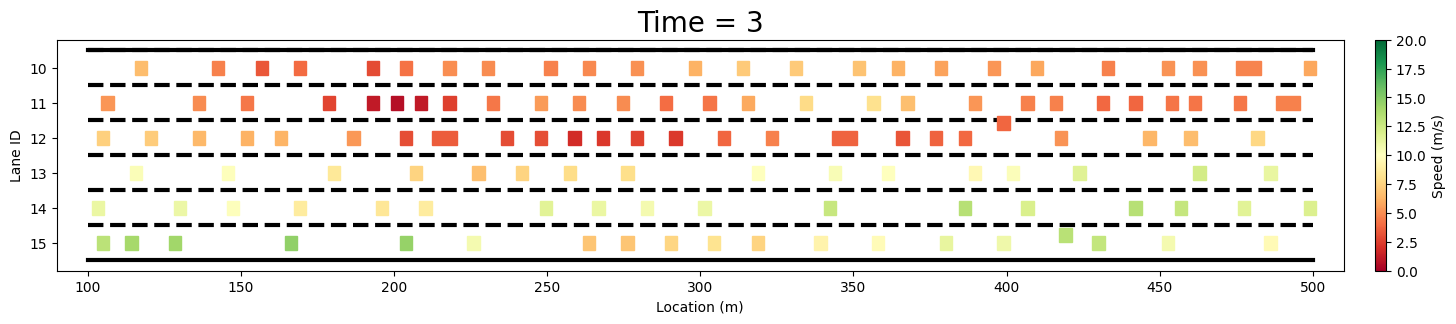

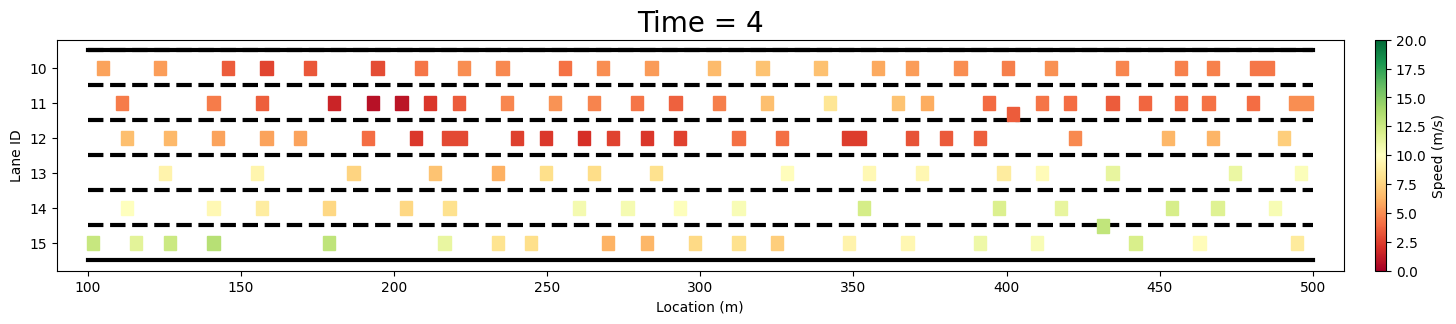

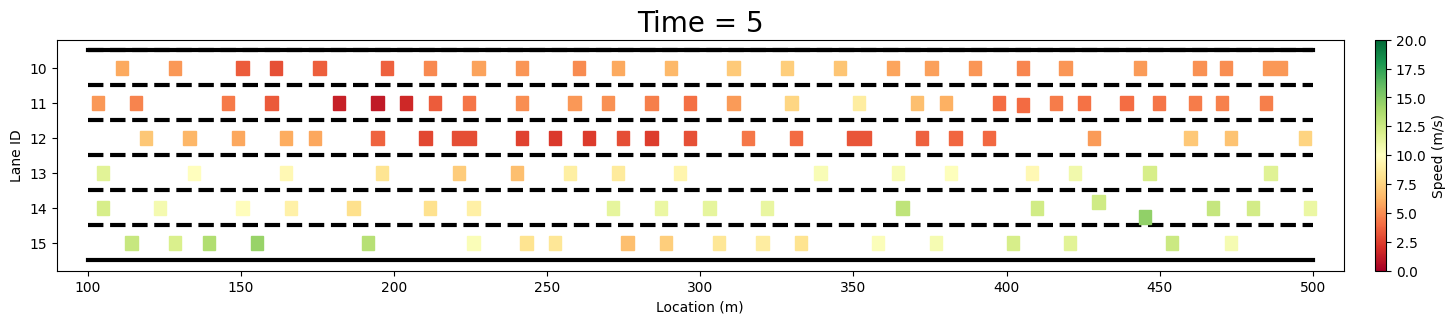

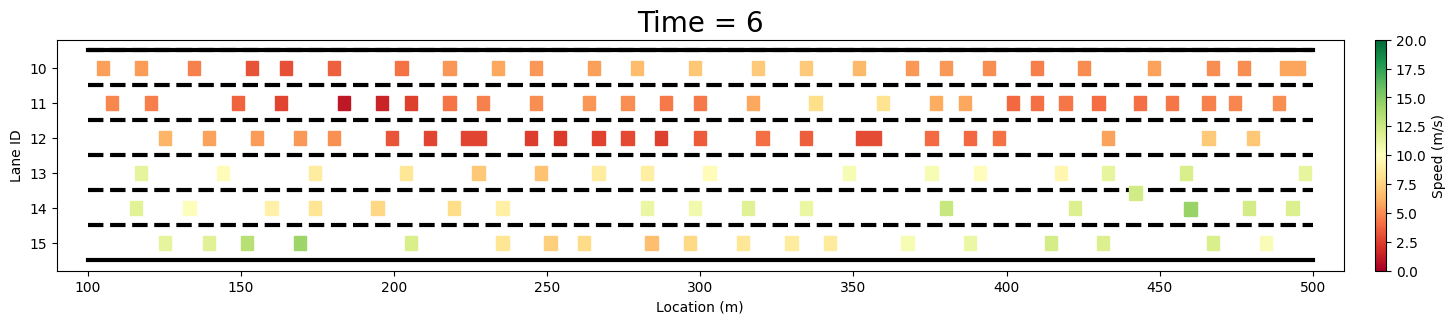

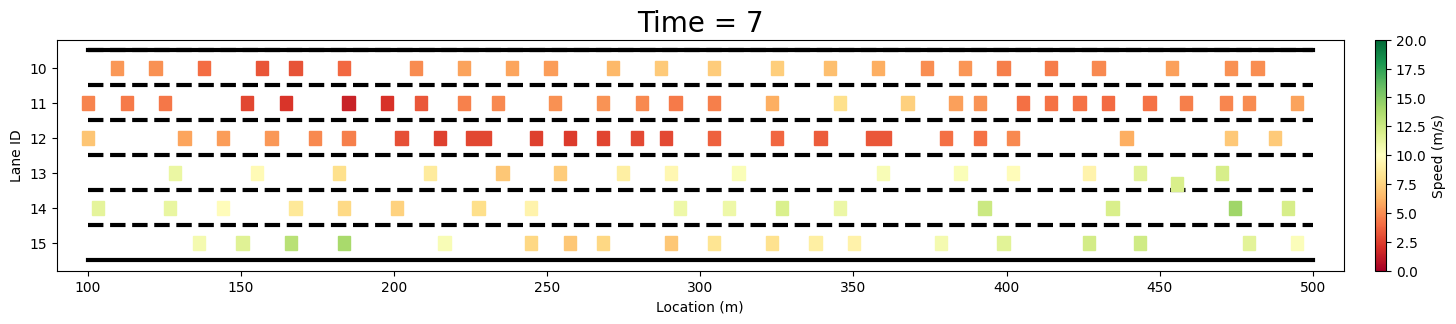

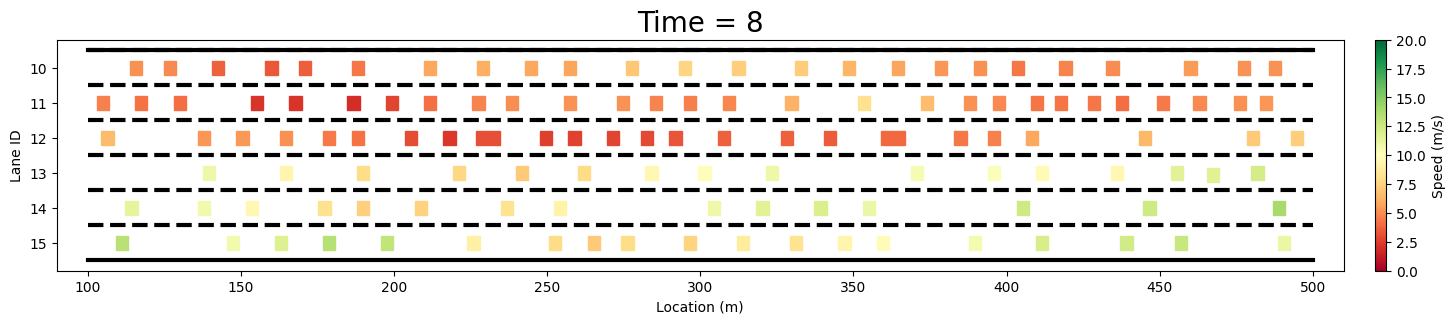

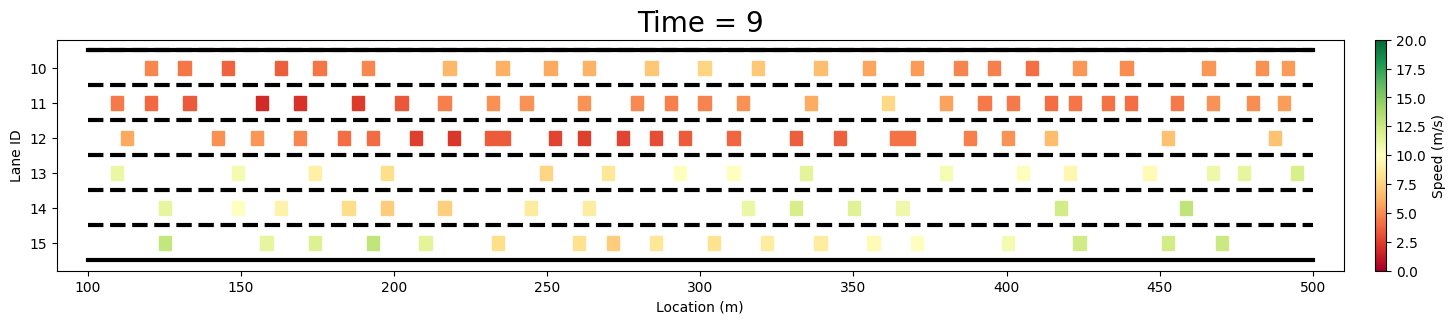

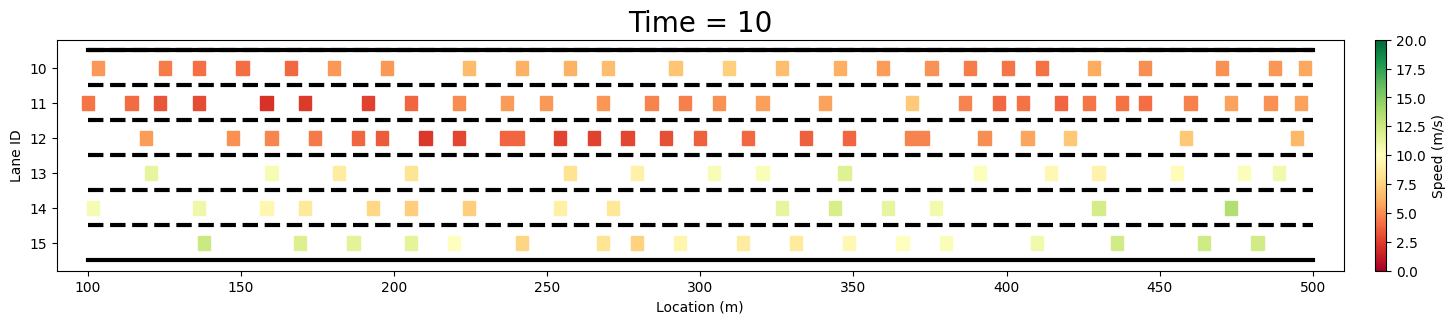

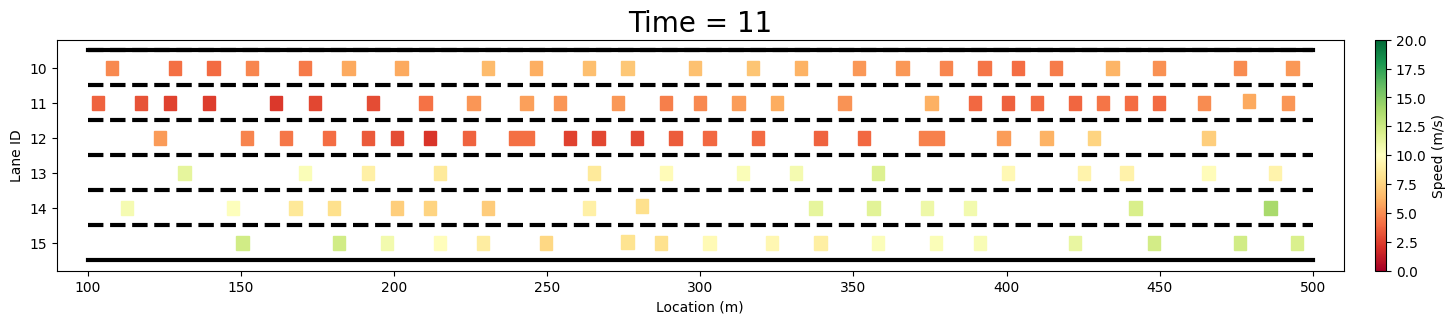

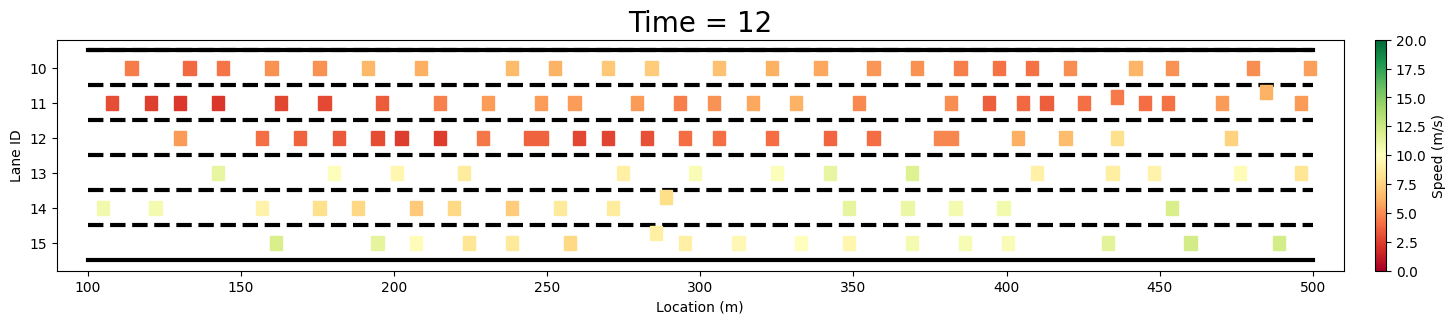

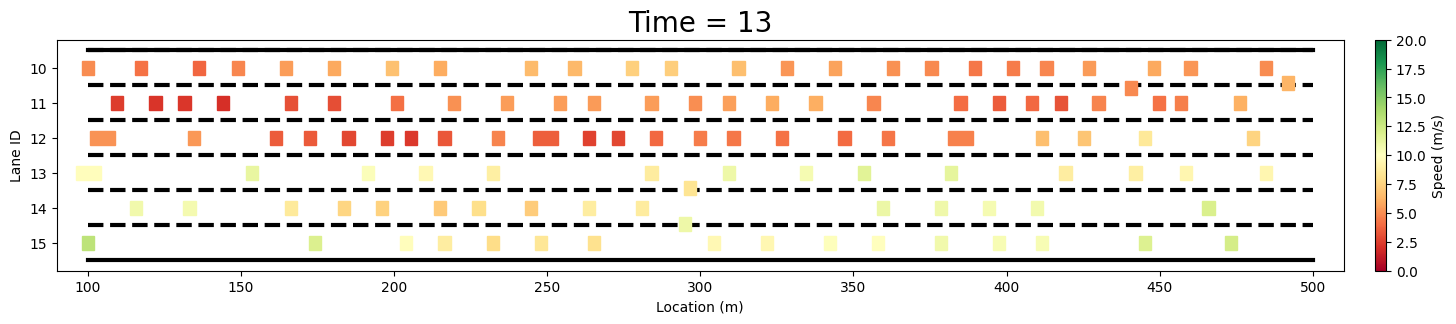

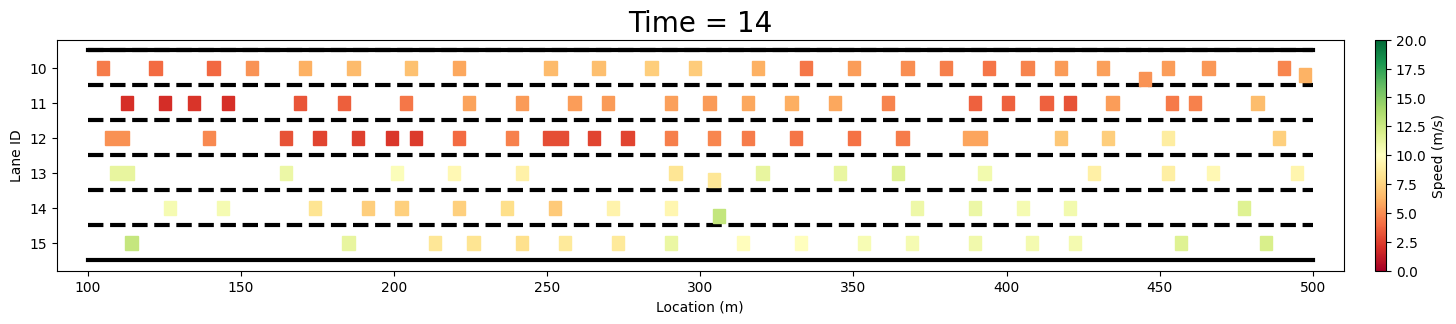

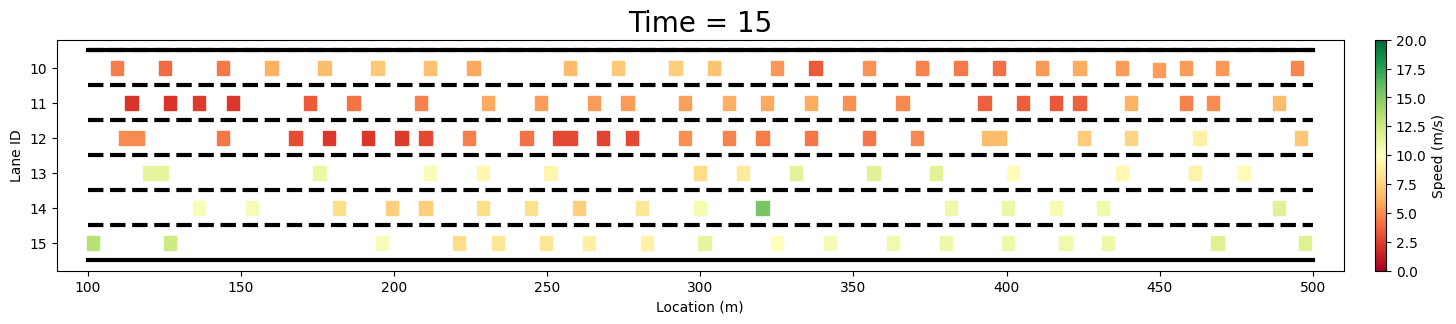

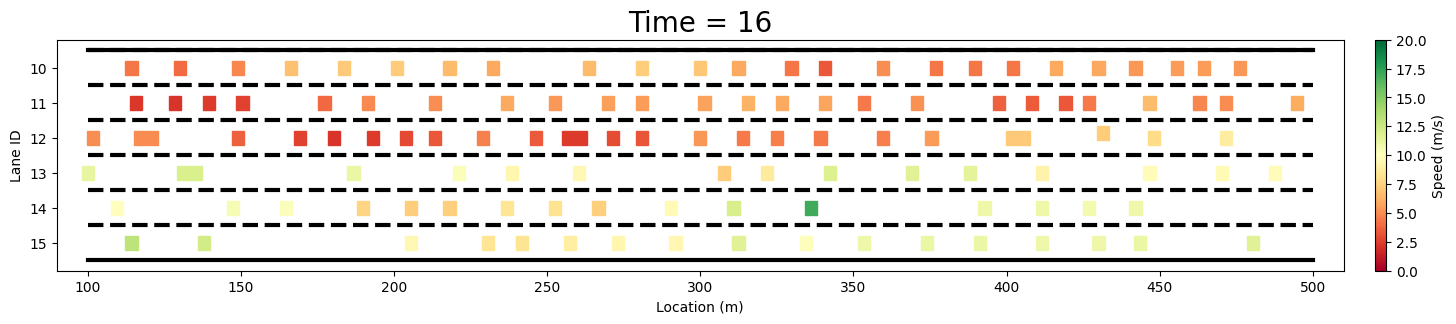

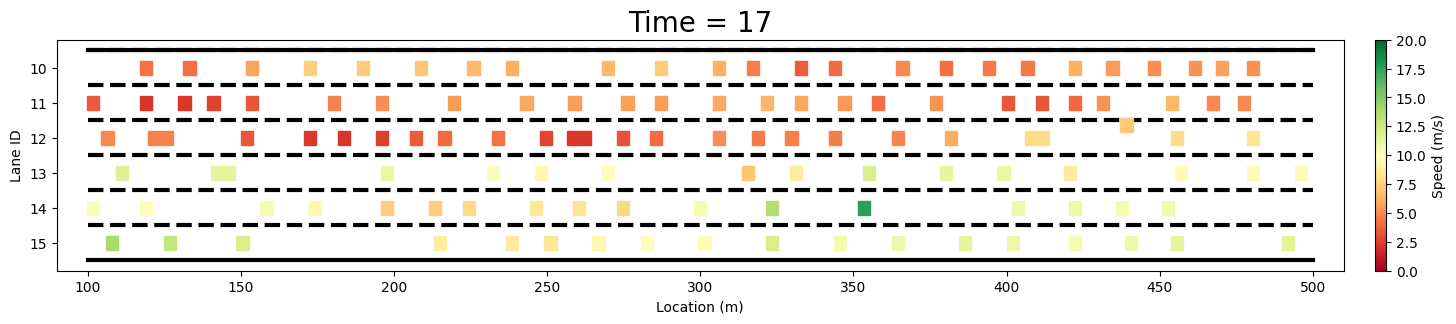

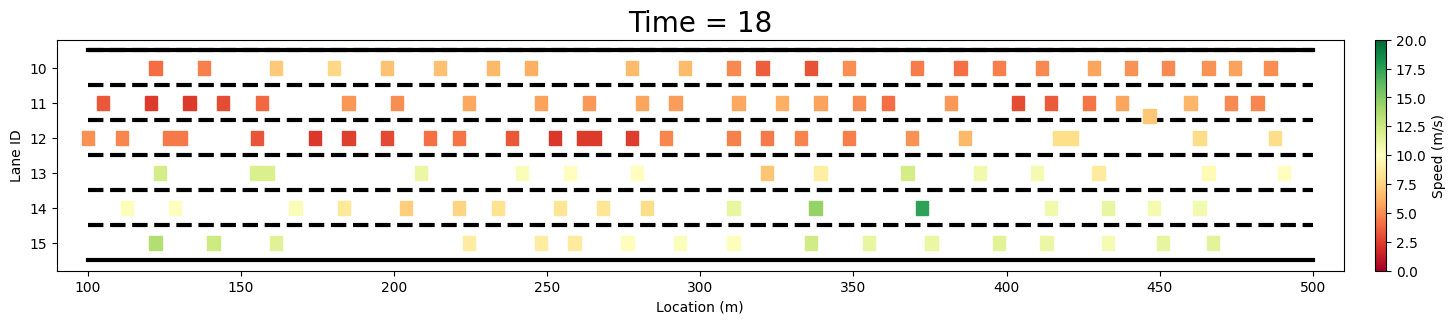

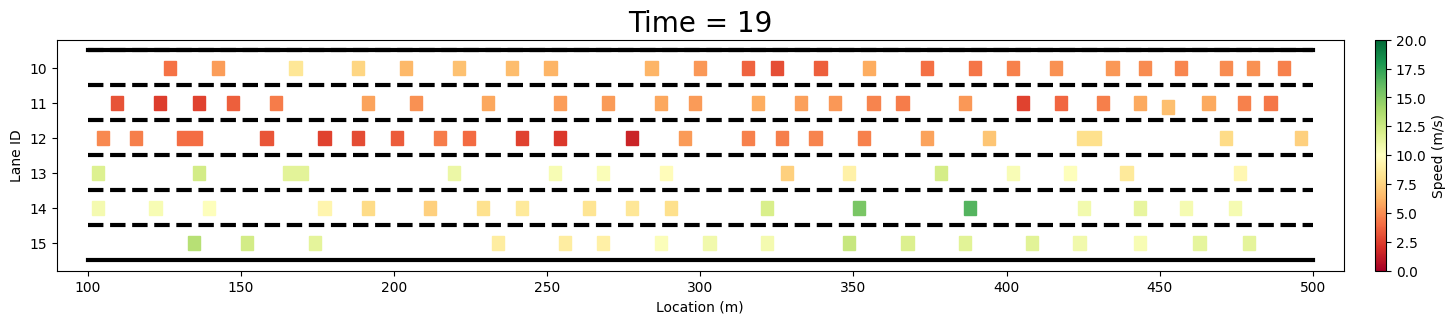

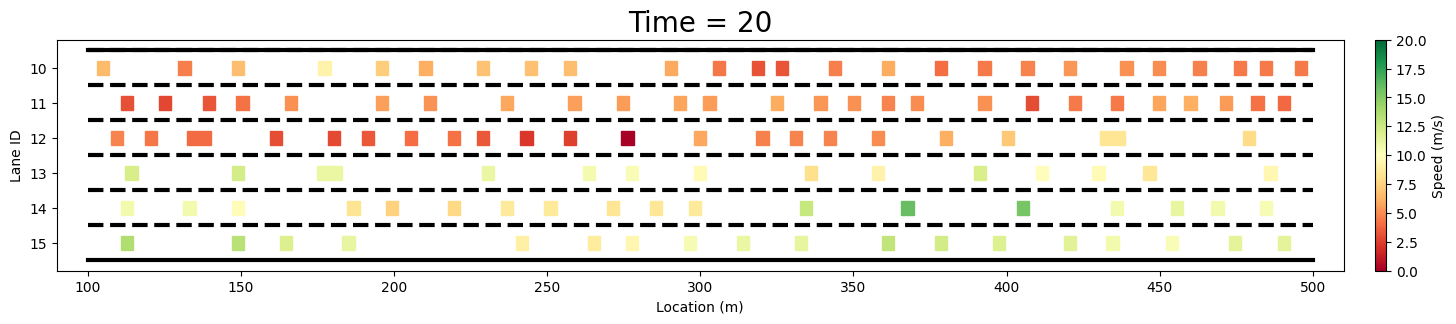

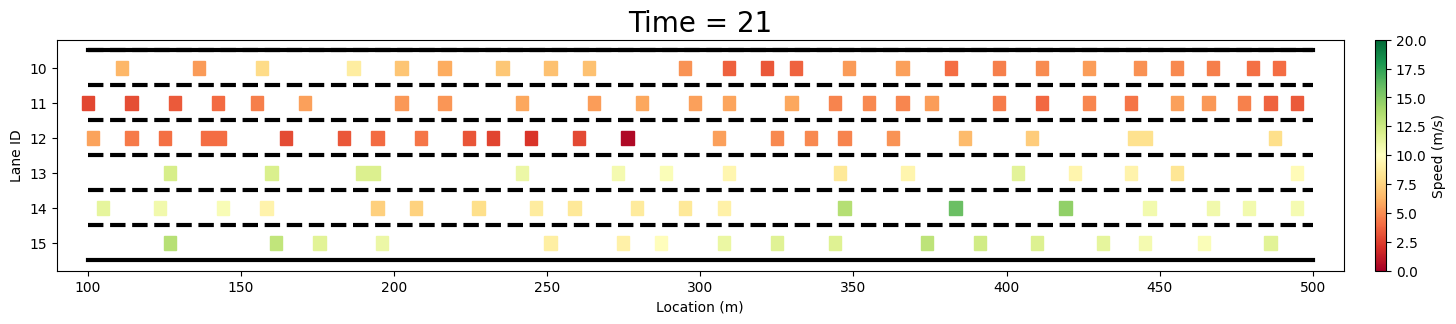

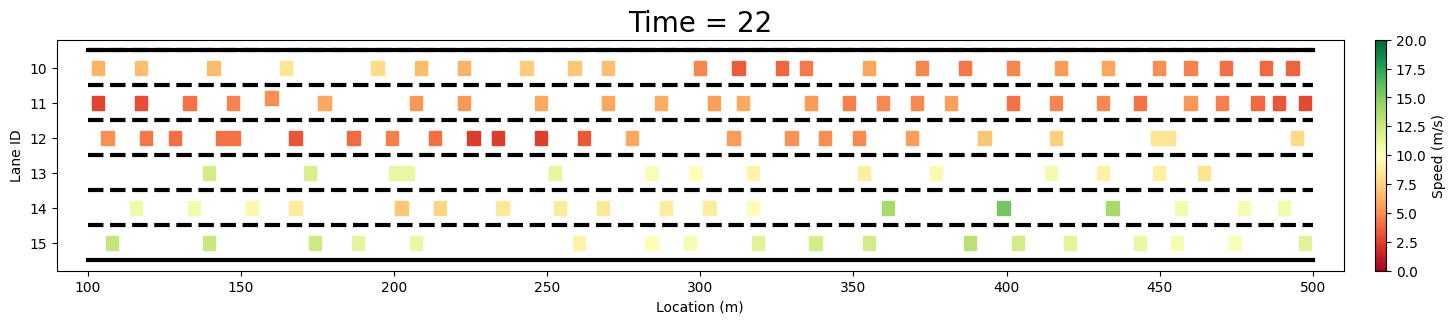

In [ ]:
font_size= 10

for t in range(min_t, max_t):
  fig, ax = plt.subplots(figsize=(20,3))

  for lane in all_lanes:
    plt.plot([min_x, max_x],[lane - 0.5, lane -0.5], color="black", linestyle="--", linewidth =3, zorder=0)

  plt.plot([min_x, max_x],[min(all_lanes) - 0.5, min(all_lanes) -0.5], color="black", linewidth =3, zorder=0)
  plt.plot([min_x, max_x],[max(all_lanes) + 0.5, max(all_lanes) + 0.5], color="black", linewidth =3, zorder=0)

  data_t = rel_data[rel_data["time"]==t]
  ids= data_t["ID"].unique()
  for id in ids:
    vehicle = data_t[data_t["ID"]==id]
    lane = vehicle["lane_vis"].values[0]
    x = vehicle["dist_cntr"].values[0]
    veh_type = vehicle["type-most-common"].values[0]
    spd = vehicle["speed-kf"].values[0]

    # veh size
    if veh_type == "large-vehicle":
      l=8
      w=0.4
    else:
      l=4
      w=0.4

    # color
    c_norm = colors.Normalize(vmin=0, vmax=20)
    cmap = cm.get_cmap("RdYlGn")
    color = cmap(c_norm(spd))

    rect = Rectangle((x - l/2, lane - w/2), l, w, color=color)
    ax.add_patch(rect)


  ax.invert_yaxis() # only do for I90/94


  ax.tick_params(axis='x', labelsize=font_size)
  ax.tick_params(axis='y', labelsize=font_size)

  plt.title("Time = " + str(t), fontsize=20)
  plt.xlabel("Location (m)", fontsize=font_size)
  plt.ylabel("Lane ID", fontsize=font_size)
  plt.xlim(min_x-10, max_x+10)


  sm = ScalarMappable(cmap=cmap, norm=c_norm)
  sm.set_array([])  # dummy array for colorbar
  cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
  cbar.set_label('Speed (m/s)', fontsize=font_size)
  cbar.ax.tick_params(labelsize=font_size)
  plt.savefig(animation_dir+"/img"+str(t)+".png", dpi=100)

  plt.show()


In [9]:
import cv2
import os
from natsort import natsorted  # Optional: for natural sorting like 1,2,10 instead of 1,10,2

# === Set the folder with images ===
image_folder = animation_dir  # Replace with your folder path
video_name = 'I90_94_animation.mp4'

# === Get list of image files ===
images = [img for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
images = natsorted(images)  # Ensures correct order like frame1, frame2, ...

# === Read the first image to get dimensions ===
first_frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, _ = first_frame.shape

# === Define video writer ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for .avi files
video = cv2.VideoWriter(video_name, fourcc, fps=4, frameSize=(width, height))

# === Write each frame ===
for image in images:

    frame = cv2.imread(os.path.join(image_folder, image))


    if frame is None:
        print("Unreadable image:", os.path.join(image_folder, image))

    video.write(frame)

video.release()
print(f"Video saved as {video_name}")

Video saved as I90_94_animation.mp4
